In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 目的：スペインの電力価格を予測
# 目的変数：スペインの電力価格(actual_price)
# 評価指標：RME

import numpy as np
import pandas as pd
import os
import pickle
import gc
# 分布確認
!pip install ydata-profiling
from ydata_profiling import ProfileReport
# 可視化
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder,OneHotEncoder
# モデリング
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
import lightgbm as lgb
# 日本語表記
!pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline
# パラメータ最適化
!pip install optuna
import optuna

# 評価指標
from sklearn.metrics import mean_squared_error

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.2 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=258c1505fdfad00ab845b1771af405d1c33806909ee50b7c1da7043c3d268539
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 38.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=a29799cd5de38dd2220985a598572afde632e3f6e536f54b141d8d63da8670ce
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize-matplotlib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 1.6 MB/s eta 0:00:00


In [4]:
file_path = '/content/drive/MyDrive/Colab Notebooks/signate/smbc/'

df_train = pd.read_csv(file_path + 'train.csv')
df_test = pd.read_csv(file_path + 'test.csv')
df_sample = pd.read_csv(file_path + 'sample_submit.csv',header=None)

In [5]:
print(df_train.shape)
display(df_train.head())
display(df_train.info())

(26280, 92)


,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,seville_weather_main,seville_weather_description,seville_weather_icon,price_actual
0,2015-01-02 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,33,0.0,0.0,0.0,0,800,clear,sky is clear,01n,64.02
1,2015-01-02 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,33,0.0,0.0,0.0,0,800,clear,sky is clear,01n,58.46
2,2015-01-02 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,54.70
3,2015-01-02 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,54.91
4,2015-01-02 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,53.07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 92 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         26280 non-null  object 
 1   generation_biomass                           26259 non-null  float64
 2   generation_fossil_brown_coal/lignite         26260 non-null  float64
 3   generation_fossil_gas                        26260 non-null  float64
 4   generation_fossil_hard_coal                  26260 non-null  float64
 5   generation_fossil_oil                        26259 non-null  float64
 6   generation_hydro_pumped_storage_consumption  26259 non-null  float64
 7   generation_hydro_run_of_river_and_poundage   26259 non-null  float64
 8   generation_hydro_water_reservoir             26260 non-null  float64
 9   generation_nuclear                           26261 non-null  float64
 10

None

In [ ]:
print(df_test.shape)
display(df_test.head())
display(df_test.info())

(8760, 91)


,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,seville_wind_speed,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,seville_weather_main,seville_weather_description,seville_weather_icon
0,2018-01-01 00:00:00+01:00,279.0,0.0,3927.0,895.0,189.0,230.0,1069.0,1893.0,7104.0,...,1,343,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2018-01-01 01:00:00+01:00,282.0,0.0,3948.0,878.0,177.0,1269.0,1058.0,1024.0,7101.0,...,1,343,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2018-01-01 02:00:00+01:00,283.0,0.0,3791.0,890.0,175.0,2197.0,1052.0,888.0,7100.0,...,1,0,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2018-01-01 03:00:00+01:00,280.0,0.0,3671.0,881.0,175.0,2965.0,1032.0,645.0,7101.0,...,1,40,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2018-01-01 04:00:00+01:00,286.0,0.0,3460.0,861.0,173.0,2705.0,1001.0,661.0,7101.0,...,1,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 91 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         8760 non-null   object 
 1   generation_biomass                           8758 non-null   float64
 2   generation_fossil_brown_coal/lignite         8758 non-null   float64
 3   generation_fossil_gas                        8758 non-null   float64
 4   generation_fossil_hard_coal                  8758 non-null   float64
 5   generation_fossil_oil                        8758 non-null   float64
 6   generation_hydro_pumped_storage_consumption  8758 non-null   float64
 7   generation_hydro_run_of_river_and_poundage   8758 non-null   float64
 8   generation_hydro_water_reservoir             8758 non-null   float64
 9   generation_nuclear                           8758 non-null   float64
 10  

None

In [6]:
# 時刻をdatetimeに変換
df_train["time"] = pd.to_datetime(df_train["time"],utc=True)
df_test["time"] = pd.to_datetime(df_test["time"],utc=True)

# 年情報のカラム作成（クロスバリデーション用）
df_train["year"] = df_train["time"].dt.year
df_test["year"] = df_test["time"].dt.year

# ケルビンを摂氏に変換  - 273.15
cities = ["valencia","madrid","bilbao","barcelona","seville"]
for city in cities:
  df_train[f"{city}_temp"] = df_train[f"{city}_temp"] - 273.15
  df_train[f"{city}_temp_min"] = df_train[f"{city}_temp_min"] - 273.15
  df_train[f"{city}_temp_max"] = df_train[f"{city}_temp_max"] - 273.15

## 特徴量エンジニアリング

In [7]:
# 季節性（spring:1,summer:2,autumn:3,winter:4）
def get_season(month):
    if month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3
    else:
        return 4

# 月を取得 → 季節に変換
df_train["month"] = df_train["time"].dt.month
df_train["season"] = df_train["month"].apply(get_season)

# テストデータにも
df_test["month"] = df_test["time"].dt.month
df_test["season"] = df_test["month"].apply(get_season)

In [8]:
# 時間帯（morning:1,afternoon:2,evening:3,night:4）

def get_time_of_day(hour):
    if 5 <= hour < 11:
        return 1
    elif 11 <= hour < 17:
        return 2
    elif 17 <= hour < 21:
        return 3
    else:
        return 4

df_train["hour"] = df_train["time"].dt.hour
df_train["time_of_day"] = df_train["hour"].apply(get_time_of_day)

# テストデータにも
df_test["hour"] = df_test["time"].dt.hour
df_test["time_of_day"] = df_test["hour"].apply(get_time_of_day)

In [9]:
# 週末フラグ

def is_week_end(weekday):
    if weekday in [0,1,2,3,4]:
      return 0
    elif weekday in [5,6]:
      return 1
    else:
      return 2

df_train["weekday"] = df_train["time"].dt.weekday
df_train["is_weekend"] = df_train["weekday"].apply(is_week_end)

# テストデータにも
df_test["weekday"] = df_test["time"].dt.weekday
df_test["is_weekend"] = df_test["weekday"].apply(is_week_end)

In [10]:
# 発電量の和
generation_columns = [col for col in df_train.columns if 'generation' in col]
df_train['generation_sum'] = df_train[generation_columns].sum(axis=1)
df_test['generation_sum'] = df_test[generation_columns].sum(axis=1)

In [11]:
# 発電量のうちの火力発電の構成比[fossil]再生可能エネルギー構成比[renewable]
df_train['generation_sum'] = df_train[generation_columns].sum(axis=1)
df_test['generation_sum'] = df_test[generation_columns].sum(axis=1)

# --- ② 分子になる電源グループ ---
df_train["fossil_total"]     = (
        df_train["generation_fossil_gas"]
      + df_train["generation_fossil_hard_coal"]
      + df_train["generation_fossil_oil"]
)
df_test["fossil_total"]      = (
        df_test["generation_fossil_gas"]
      + df_test["generation_fossil_hard_coal"]
      + df_test["generation_fossil_oil"]
)

df_train["renewable_total"]  = (
        df_train["generation_hydro_pumped_storage_consumption"]
      + df_train["generation_hydro_run_of_river_and_poundage"]
      + df_train["generation_hydro_water_reservoir"]
      + df_train["generation_other_renewable"]
)
df_test["renewable_total"]   = (
        df_test["generation_hydro_pumped_storage_consumption"]
      + df_test["generation_hydro_run_of_river_and_poundage"]
      + df_test["generation_hydro_water_reservoir"]
      + df_test["generation_other_renewable"]
)

# --- ③ 比率を安全に計算（0 除算防止） ---
eps = 1e-6
df_train["fossil_share"]     = df_train["fossil_total"]    / (df_train["generation_sum"] + eps)
df_test["fossil_share"]      = df_test["fossil_total"]     / (df_test["generation_sum"]  + eps)

df_train["renewable_share"]  = df_train["renewable_total"] / (df_train["generation_sum"] + eps)
df_test["renewable_share"]   = df_test["renewable_total"]  / (df_test["generation_sum"]  + eps)

In [12]:
import holidays, numpy as np

es_holidays = holidays.Spain(years=[2015, 2016, 2017, 2018])

for df in (df_train, df_test):
    df["is_holiday"] = df["time"].dt.date.map(lambda d: 1 if d in es_holidays else 0)
    # 前後1日
    for s in [-1, 1]:
        df[f"hol_adj{s}"] = df["is_holiday"].shift(s).fillna(0)
    # 3連休以上を flag
    df["is_long_wend"] = (
        (df["is_holiday"].rolling(3, min_periods=1).sum() >= 2).astype(int)
    )

## データ分割＆モデル実装

In [13]:
# カテゴリカルカラムの抜き出し
categorical_cols = [
    col for col in df_train.select_dtypes(include=['object', 'category']).columns
    if col != "price_actual"
    ]
# 数値カラムの抜き出し
numerical_cols = [
    col for col in df_train.select_dtypes(include=['int64', 'float64']).columns
    ]
print('*'*20,'実行結果確認','*'*20,)
print(f'カテゴリ{categorical_cols}')
print(f'数値{numerical_cols}')

******************** 実行結果確認 ********************
カテゴリ['valencia_weather_main', 'valencia_weather_description', 'valencia_weather_icon', 'madrid_weather_main', 'madrid_weather_description', 'madrid_weather_icon', 'bilbao_weather_main', 'bilbao_weather_description', 'bilbao_weather_icon', 'barcelona_weather_main', 'barcelona_weather_description', 'barcelona_weather_icon', 'seville_weather_main', 'seville_weather_description', 'seville_weather_icon']
数値['generation_biomass', 'generation_fossil_brown_coal/lignite', 'generation_fossil_gas', 'generation_fossil_hard_coal', 'generation_fossil_oil', 'generation_hydro_pumped_storage_consumption', 'generation_hydro_run_of_river_and_poundage', 'generation_hydro_water_reservoir', 'generation_nuclear', 'generation_other', 'generation_other_renewable', 'generation_solar', 'generation_waste', 'generation_wind_onshore', 'total_load_actual', 'valencia_temp', 'valencia_temp_min', 'valencia_temp_max', 'valencia_pressure', 'valencia_humidity', 'valencia_wi

In [25]:
# 特徴量の整理

base_features = [
    'generation_fossil_gas',
    'generation_fossil_hard_coal',
    'generation_fossil_oil',
    'generation_hydro_pumped_storage_consumption',
    'generation_hydro_run_of_river_and_poundage',
    'generation_hydro_water_reservoir',
    'generation_other_renewable',
    'total_load_actual',
    #"season",
    #"time_of_day",
    #"is_weekend",
    #"is_holiday",
    #"hol_adj1",
    #"hol_adj-1",
    #"is_long_wend",
    #'generation_sum',
    #"fossil_share",
    #"renewable_share"
]
add_features = []

# 目的変数のSeries作成
y_train = df_train["price_actual"]

In [16]:
def expanding_quarter_folds(df, val_quarters):

  """
    四半期 (Q) 単位で検証セットを作り、残りを“それ以前すべて”で学習セットにする
    arg:
        df:df
        データフレーム
        val_quarters:list
        クォーター区切るためのリスト
    Returns:
        folds:tupple
        検証セット用のタプル

  """
  folds = []
  q_series = df["time"].dt.to_period("Q").astype(str)

  for q in val_quarters:
      va_idx = df.index[q_series == q]
      if len(va_idx) == 0:                 # ✧ 追加 ✧
          continue                         # データが無い四半期をスキップ

      first_ts = df.loc[va_idx, "time"].min()
      tr_idx   = df.index[df["time"] < first_ts]
      if len(tr_idx) == 0:                 # 念のため
          continue

      folds.append((tr_idx.values, va_idx.values))
  return folds

In [21]:
# ------------------------------------------------------------
# LightGBM + Expanding-Window CV
# ------------------------------------------------------------
def light_gbm_model(input_x, input_y, input_test,
                    base_features, add_features,
                    params,
                    val_quarters = ["2017Q1", "2017Q2", "2017Q3", "2017Q4"],
                    SEEDS = [0, 1, 2, 3, 4]):
    """
    LightGBM で Expanding-Window（2017Q1-Q4）× seed アンサンブルを回す。

    Returns
    -------
    oof : np.ndarray  – val 行に予測値（それ以外 NaN）
    test_pred : np.ndarray  – テスト平均予測
    rmse_list : list[float] – fold ごとの RMSE
    feature_importance : pd.DataFrame – fold/seed 平均 Gain
    """
    features = base_features + add_features

    # ---- folds 作成 ----
    folds = expanding_quarter_folds(input_x, val_quarters)

    oof        = np.full(len(input_x), np.nan)      # ← NaN で初期化
    test_pred  = np.zeros(len(input_test))
    rmse_list  = []
    fi_frames  = []

    # ========== fold ループ ==========
    for f, (tr_idx, va_idx) in enumerate(folds, start=1):
        print(f"========== Fold {f} ({val_quarters[f-1]}) ==========")
        val_pred_fold = np.zeros(len(va_idx))

        for s in SEEDS:
            x_tr, y_tr = input_x.loc[tr_idx, features], input_y.loc[tr_idx]
            x_va, y_va = input_x.loc[va_idx, features], input_y.loc[va_idx]

            model = lgb.LGBMRegressor(**params, random_state=s)
            model.fit(
                x_tr, y_tr,
                eval_set=[(x_va, y_va)],
                eval_metric="rmse",
                callbacks=[lgb.early_stopping(100),
                           lgb.log_evaluation(50)]
            )

            # ---- 予測 ----
            val_pred_fold += model.predict(x_va) / len(SEEDS)
            test_pred     += model.predict(input_test[features]) / (len(SEEDS) * len(folds))

            fi_frames.append(
                pd.DataFrame({
                    "feature": features,
                    "gain": model.booster_.feature_importance(importance_type="gain"),
                    "fold": f,
                    "seed": s
                })
            )

        # ---- fold 終了後 RMSE ----
        fold_rmse = np.sqrt(mean_squared_error(y_va, val_pred_fold))
        rmse_list.append(fold_rmse)
        print(f"Fold {f} RMSE = {fold_rmse:.4f}")

        oof[va_idx] = val_pred_fold          # NaN → 予測値に置換

    # ========== OOF が埋まった行だけで CV RMSE ==========
    mask_val = ~np.isnan(oof)
    cv_rmse = np.sqrt(mean_squared_error(input_y[mask_val], oof[mask_val]))
    print(f"\nOverall CV RMSE (val rows) = {cv_rmse:.4f}")

    # ---- 重要度を fold/seed 平均で集計 ----
    feature_importance = (
        pd.concat(fi_frames)
          .groupby("feature")["gain"].mean()
          .sort_values(ascending=False)
          .reset_index()
    )

    return oof, test_pred, rmse_list, feature_importance

In [18]:
# パラメータ
params = {
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':'rmse',
    'learning_rate':0.05,
    'num_leaves':12,
    'max_depth':-1,
    'n_estimators':5000,
    "force_col_wise": True,
    'importance_type':'gain'
}

<ipython-input-75-164526801>:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  q_series = df["time"].dt.to_period("Q").astype(str)


========== Fold 1 (2017Q1) ==========
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11522
[LightGBM] [Info] Number of data points in the train set: 17521, number of used features: 87
[LightGBM] [Info] Start training from score 54.379606
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 22.2364
[100]	valid_0's rmse: 22.3118
Early stopping, best iteration is:
[1]	valid_0's rmse: 19.3388
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11522
[LightGBM] [Info] Number of data points in the train set: 17521, number of used features: 87
[LightGBM] [Info] Start training from score 54.379606
Training until validation 

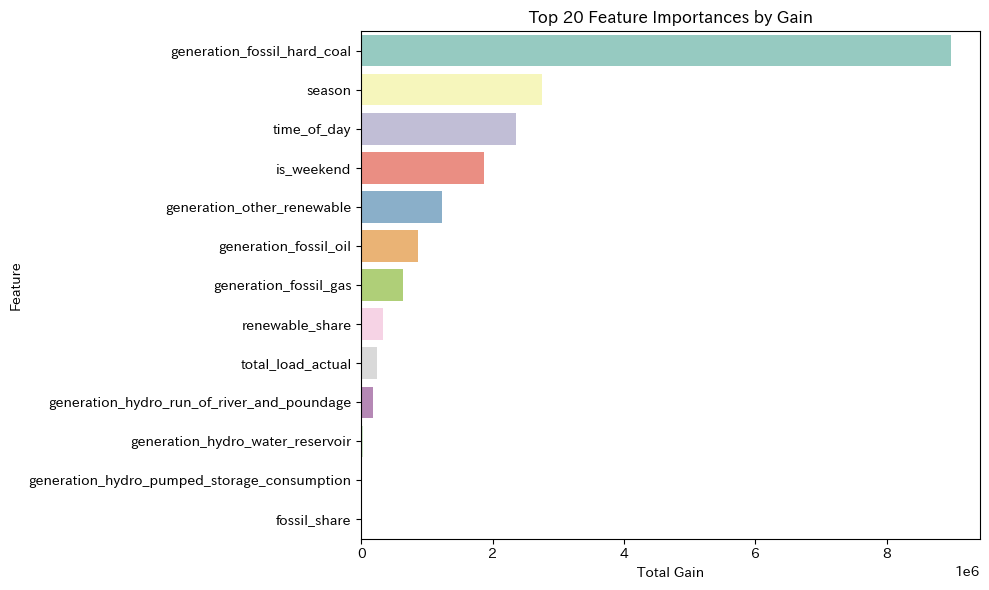

In [ ]:
# 関数の実行
oof, preds, rmse_each_fold, fi = light_gbm_model(
    df_train, df_train["price_actual"], df_test,
    base_features, add_features,
    params
)
print("Fold-wise RMSE:", np.round(rmse_each_fold, 4))
print(f"RMSE  mean={np.mean(rmse_each_fold):.4f}  std={np.std(rmse_each_fold):.4f}")

# ソート
feature_importance = feature_importance.sort_values('gain', ascending=False)

# 上位20個をプロット
plt.figure(figsize=(10, 6))
sns.barplot(
    x='gain',
    y='feature',
    hue='feature',
    data=feature_importance.head(20),
    palette='Set3',
    legend=False
    )
plt.title("Top 20 Feature Importances by Gain")
plt.xlabel("Total Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## 冬だけモデルの追加

In [26]:



# Winter/not-Winterの切り分けマスクを df_train で生成
winter_months = [12, 1, 2]
winter_mask_train = df_train["time"].dt.month.isin(winter_months)
winter_mask_test = df_test ["time"].dt.month.isin(winter_months)

print("▶ mask counts",
      winter_mask_train.sum(), (~winter_mask_train).sum(),
      winter_mask_test.sum(), (~winter_mask_test).sum())

# trainデータには冬の行と非冬の行が存在する
assert winter_mask_train.any() and (~winter_mask_train).any(), "冬 or 非冬 行が 0 行です"

# 冬用にパラメータ更新 左側の辞書をベースに右側とキーが重なれば右側で上書き
params_w = params | {"num_leaves":31, "min_data_in_leaf":50, "learning_rate":0.03,"verbosity":-1}

# 実行用の関数
def run_part(df_sub, df_test_sub, par):
    oof, pred, *_ = light_gbm_model( #lgb関数の引数残り2つはいらない
        df_sub.reset_index(drop=True),
        df_sub["price_actual"].reset_index(drop=True),
        df_test_sub.reset_index(drop=True),
        base_features, add_features,
        par
    )
    return oof, pred

# ---------- 非冬 ----------
oof_base, pred_base = run_part(
    df_train.loc[~winter_mask_train],
    df_test.loc[~winter_mask_test],
    params
)

# ---------- 冬 ----------
oof_w, pred_w = run_part(
    df_train.loc[winter_mask_train],
    df_test.loc[winter_mask_test],
    params_w
)

# ---------- マージ ----------
oof_final  = np.full(len(df_train), np.nan)
pred_final = np.zeros(len(df_test))

oof_final[~winter_mask_train] = oof_base
oof_final[winter_mask_train]  = oof_w

pred_final[~winter_mask_test] = pred_base
pred_final[winter_mask_test]  = pred_w

mask_val = ~np.isnan(oof_final)
cv_rmse  = np.sqrt(((oof_final[mask_val] -
                     df_train.loc[mask_val,"price_actual"])**2).mean())
print("CV RMSE (split model):", cv_rmse)


▶ mask counts 6480 19800 2160 6600
========== Fold 1 (2017Q1) ==========
Training until validation scores don't improve for 100 rounds


<ipython-input-16-1113048596>:16: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  q_series = df["time"].dt.to_period("Q").astype(str)


[50]	valid_0's rmse: 8.65765
[100]	valid_0's rmse: 8.80054
Early stopping, best iteration is:
[17]	valid_0's rmse: 8.37349
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 8.65765
[100]	valid_0's rmse: 8.80054
Early stopping, best iteration is:
[17]	valid_0's rmse: 8.37349
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 8.65765
[100]	valid_0's rmse: 8.80054
Early stopping, best iteration is:
[17]	valid_0's rmse: 8.37349
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 8.65765
[100]	valid_0's rmse: 8.80054
Early stopping, best iteration is:
[17]	valid_0's rmse: 8.37349
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 8.65765
[100]	valid_0's rmse: 8.80054
Early stopping, best iteration is:
[17]	valid_0's rmse: 8.37349
Fold 1 RMSE = 8.3735
========== Fold 2 (2017Q2) ==========
Training until validation scores don't improve for 100 rounds
[50]	valid_0's r

<ipython-input-16-1113048596>:16: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  q_series = df["time"].dt.to_period("Q").astype(str)


[100]	valid_0's rmse: 19.3285
[150]	valid_0's rmse: 19.3804
Early stopping, best iteration is:
[79]	valid_0's rmse: 19.2131
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 19.2858
[100]	valid_0's rmse: 19.3285
[150]	valid_0's rmse: 19.3804
Early stopping, best iteration is:
[79]	valid_0's rmse: 19.2131
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 19.2858
[100]	valid_0's rmse: 19.3285
[150]	valid_0's rmse: 19.3804
Early stopping, best iteration is:
[79]	valid_0's rmse: 19.2131
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 19.2858
[100]	valid_0's rmse: 19.3285
[150]	valid_0's rmse: 19.3804
Early stopping, best iteration is:
[79]	valid_0's rmse: 19.2131
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 19.2858
[100]	valid_0's rmse: 19.3285
[150]	valid_0's rmse: 19.3804
Early stopping, best iteration is:
[79]	valid_0's rmse: 19.2131
Fold 1 RMSE = 19

In [24]:
from datetime import datetime, timedelta, timezone
from zoneinfo import ZoneInfo   # 3.9 から標準搭載

# ① まずは “現在の UTC 時刻” を取得
utc_now = datetime.now(timezone.utc)

# ② UTC → JST(+9) に変換して、日付部分だけ取り出す
today = utc_now.astimezone(ZoneInfo("Asia/Tokyo")).date()

df_sub = pd.read_csv(file_path + 'sample_submit.csv',header=None)

print("pred_final 5-number summary:")
print(pd.Series(pred_final).describe(percentiles=[.25,.5,.75]))

submission = pd.DataFrame({
    'time':df_sub.iloc[:, 0] ,
    'pred': pred_final
})
submission.to_csv(f'submission_{today}.csv', index=False, header=False)
print(f'✅ Submission file saved as submission_{today}.csv')

pred_final 5-number summary:
count    8760.000000
mean       53.379483
std         5.508838
min        31.393876
25%        50.465842
50%        52.758180
75%        56.549676
max        79.942303
dtype: float64
✅ Submission file saved as submission_2025-06-17.csv
